In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.metrics import *
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    OrdinalEncoder,
    TargetEncoder,
    FunctionTransformer,
)

sklearn.set_config(transform_output="pandas")

from catboost import CatBoostRegressor

import lightgbm as lgb

import xgboost as xgb

from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold

# for model learning
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    cross_val_score,
)

# tunning hyperparamters model
import optuna

/home/dmitry/elbrus/Phase1/week2_project_houses/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test = pd.read_csv("./data/train.csv")

test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
X = test.drop("SalePrice", axis=1).copy()
y = np.log(test["SalePrice"].copy())

In [4]:
X.shape

(1460, 80)

#### Делаем список с количеством уникальных значений по колонкам

In [5]:
num_of_unique = {}
for c in X.columns:
    num_of_unique[c] = test[c].nunique()
num_of_unique

{'Id': 1460,
 'MSSubClass': 15,
 'MSZoning': 5,
 'LotFrontage': 110,
 'LotArea': 1073,
 'Street': 2,
 'Alley': 2,
 'LotShape': 4,
 'LandContour': 4,
 'Utilities': 2,
 'LotConfig': 5,
 'LandSlope': 3,
 'Neighborhood': 25,
 'Condition1': 9,
 'Condition2': 8,
 'BldgType': 5,
 'HouseStyle': 8,
 'OverallQual': 10,
 'OverallCond': 9,
 'YearBuilt': 112,
 'YearRemodAdd': 61,
 'RoofStyle': 6,
 'RoofMatl': 8,
 'Exterior1st': 15,
 'Exterior2nd': 16,
 'MasVnrType': 3,
 'MasVnrArea': 327,
 'ExterQual': 4,
 'ExterCond': 5,
 'Foundation': 6,
 'BsmtQual': 4,
 'BsmtCond': 4,
 'BsmtExposure': 4,
 'BsmtFinType1': 6,
 'BsmtFinSF1': 637,
 'BsmtFinType2': 6,
 'BsmtFinSF2': 144,
 'BsmtUnfSF': 780,
 'TotalBsmtSF': 721,
 'Heating': 6,
 'HeatingQC': 5,
 'CentralAir': 2,
 'Electrical': 5,
 '1stFlrSF': 753,
 '2ndFlrSF': 417,
 'LowQualFinSF': 24,
 'GrLivArea': 861,
 'BsmtFullBath': 4,
 'BsmtHalfBath': 3,
 'FullBath': 4,
 'HalfBath': 3,
 'BedroomAbvGr': 8,
 'KitchenAbvGr': 4,
 'KitchenQual': 4,
 'TotRmsAbvGrd': 12,

#### Список с кол-вом nan по колонкам

In [6]:
nan_count = pd.DataFrame(data={"NaN_count": X.isna().sum(), "data_type": X.dtypes})
cols_with_nans = nan_count[nan_count["NaN_count"] > 0].copy()
cols_with_nans

,NaN_count,data_type
LotFrontage,259,float64
Alley,1369,object
MasVnrType,872,object
MasVnrArea,8,float64
BsmtQual,37,object
BsmtCond,37,object
BsmtExposure,38,object
BsmtFinType1,37,object
BsmtFinType2,38,object
Electrical,1,object


In [7]:
cols_with_nans.shape[0]

19

In [8]:
X[X["GarageType"] == "NA"]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


#### Разделяем num и cat features по описанию в data_description.txt

In [9]:
num_features = [
    "LotFrontage",
    "LotArea",
    "YearBuilt",
    "YearRemodAdd",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "GarageYrBlt",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "YrSold",
]
cat_features = []
for c in X.columns:
    if c not in num_features and c != "Id":
        cat_features.append(c)

print(len(num_features), sep=" ")
print(len(cat_features), sep=" ")
print(len(cat_features) + len(num_features) == X.shape[1] - 1)

23
56
True


#### Проверяем все ли num признаки имеют праильный тип данных

In [10]:
test.loc[::, num_features].dtypes

LotFrontage      float64
LotArea            int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
GarageYrBlt      float64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
YrSold             int64
dtype: object

#### Посмотрим распределение цены в тренировочном датасете

''

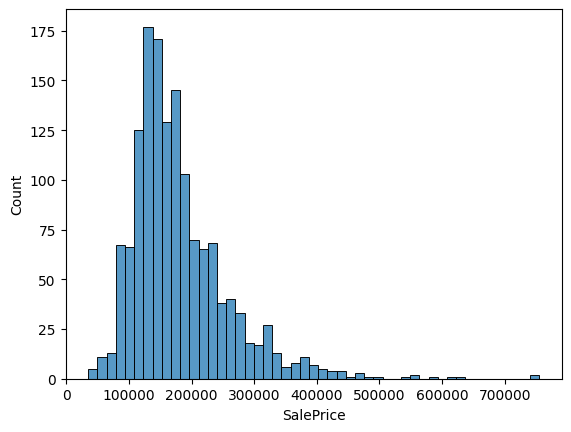

In [11]:
sns.histplot(test["SalePrice"])
;

##### Также посмотрим в логарифме

''

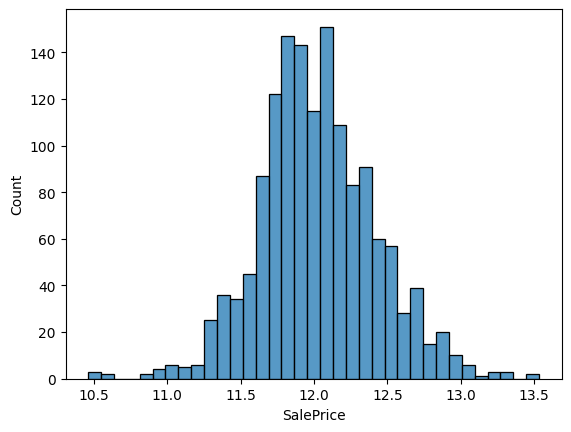

In [12]:
sns.histplot(y)
;

> **У цены хорошее распределение близкое к нормальному, отсутствуют большие выбросы. Все цены лежат в диапазоне 50к - 750к, что лежит примерно в 1 порядке.**

#### Предобработка

In [13]:
cols_with_nans

,NaN_count,data_type
LotFrontage,259,float64
Alley,1369,object
MasVnrType,872,object
MasVnrArea,8,float64
BsmtQual,37,object
BsmtCond,37,object
BsmtExposure,38,object
BsmtFinType1,37,object
BsmtFinType2,38,object
Electrical,1,object


##### Imputer

In [27]:
drop_features = [
    # "PoolArea",
    "PoolQC",
    "Fence",
    "MiscFeature",
    "MasVnrType",
    "Alley",
]

rest_cat_features = [c for c in cat_features if c not in drop_features]

imputer = ColumnTransformer(
    transformers=[
        ("drop_features", "drop", drop_features),
        (
            "imput_no",
            SimpleImputer(strategy="constant", fill_value="no"),
            rest_cat_features,
        ),  # type: ignore
        (
            "imput_numeric",
            SimpleImputer(strategy="median"),
            num_features,
            # [c for c in num_features if c not in drop_features],
        ),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)
# list(set(cat_features) - set(drop_features))
# len([c for c in cat_features if c not in drop_features])
[c for c in num_features if c not in drop_features]

['LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'YrSold']

In [28]:
scaler = ColumnTransformer(
    [("scaling_num_columns", StandardScaler(), num_features)],
    verbose_feature_names_out=False,
    remainder="passthrough",
)

In [29]:
encoder = ColumnTransformer(
    [("encoding", OrdinalEncoder(), cat_features)],
    verbose_feature_names_out=False,
    remainder="passthrough",
)

In [30]:
preprocessor = Pipeline(
    [
        ("imputer", imputer),
        ("scaler", scaler),  # ("encoder", encoder)
    ]
)

In [31]:
X_preproc = preprocessor.fit_transform(X.copy())

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_preproc, y, test_size=0.2, random_state=42
)

In [33]:
X_train.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,MoSold,SaleType,SaleCondition,Id
254,0.006190,-0.212153,-0.472560,-1.350194,-0.570750,1.049169,-0.288653,-0.396727,0.585036,0.391697,...,Attchd,RFn,1,TA,TA,Y,6,WD,Normal,255
1066,-0.493353,-0.268578,0.719786,0.442586,-0.570750,-0.973018,-0.288653,0.524681,-0.589275,-0.940928,...,Attchd,RFn,2,TA,TA,Y,5,WD,Normal,1067
638,-0.130049,-0.174369,-2.029235,-1.689368,-0.570750,-0.973018,-0.288653,0.517889,-0.596115,-0.948691,...,no,no,0,no,no,P,5,WD,Normal,639
799,-0.447940,-0.332419,-1.134975,-1.689368,0.824062,0.274948,-0.288653,-0.917424,-0.744329,-0.469981,...,Detchd,Unf,1,TA,TA,Y,6,WD,Normal,800
380,-0.902070,-0.552908,-1.565545,-1.689368,-0.570750,-0.494887,-0.288653,0.545056,-0.071666,-0.353538,...,Detchd,Unf,1,TA,TA,Y,5,WD,Normal,381


In [36]:
model = CatBoostRegressor(random_seed=42, cat_features=rest_cat_features)
model.fit(X_train, y_train)

Learning rate set to 0.04196
0:	learn: 0.3801383	total: 8.92ms	remaining: 8.91s
1:	learn: 0.3698758	total: 17.1ms	remaining: 8.53s
2:	learn: 0.3596500	total: 24.4ms	remaining: 8.11s
3:	learn: 0.3504454	total: 33ms	remaining: 8.23s
4:	learn: 0.3417461	total: 40.2ms	remaining: 7.99s
5:	learn: 0.3343620	total: 46.4ms	remaining: 7.69s
6:	learn: 0.3267918	total: 54.6ms	remaining: 7.74s
7:	learn: 0.3192445	total: 62.9ms	remaining: 7.8s
8:	learn: 0.3115249	total: 70.7ms	remaining: 7.79s
9:	learn: 0.3037956	total: 78.3ms	remaining: 7.75s
10:	learn: 0.2965497	total: 87.7ms	remaining: 7.88s
11:	learn: 0.2901804	total: 96.6ms	remaining: 7.95s
12:	learn: 0.2838344	total: 104ms	remaining: 7.92s
13:	learn: 0.2778512	total: 111ms	remaining: 7.85s
14:	learn: 0.2719669	total: 118ms	remaining: 7.77s
15:	learn: 0.2663191	total: 126ms	remaining: 7.76s
16:	learn: 0.2611006	total: 134ms	remaining: 7.78s
17:	learn: 0.2558096	total: 141ms	remaining: 7.69s
18:	learn: 0.2512679	total: 148ms	remaining: 7.62s
19:

In [37]:
# Для тренировочных данных
train_pred = model.predict(X_train)
print("MAE train:", mean_absolute_error(y_train, train_pred))
print("MSE train:", mean_squared_error(y_train, train_pred))
print("R2 train:", r2_score(y_train, train_pred))

# Для валидационных данных
valid_pred = model.predict(X_valid)
print("MAE valid:", mean_absolute_error(y_valid, valid_pred))
print("MSE valid:", mean_squared_error(y_valid, valid_pred))
print("R2 valid:", r2_score(y_valid, valid_pred))

MAE train: 0.04479024121540999
MSE train: 0.0038232473201937353
R2 train: 0.9749203800627898
MAE valid: 0.08761705257524302
MSE valid: 0.017912797335259877
R2 valid: 0.9040112554361429


In [ ]:
# Для тренировочных данных
train_pred = model.predict(X_train)
print("MAE train:", mean_absolute_error(y_train, train_pred))
print("MSE train:", mean_squared_error(y_train, train_pred))
print("R2 train:", r2_score(y_train, train_pred))

# Для валидационных данных
valid_pred = model.predict(X_valid)
print("MAE valid:", mean_absolute_error(y_valid, valid_pred))
print("MSE valid:", mean_squared_error(y_valid, valid_pred))
print("R2 valid:", r2_score(y_valid, valid_pred))